<a href="https://colab.research.google.com/github/roryclaydon1994/BrownianMotionExamples/blob/main/Copy_of_BrownianMotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides a walkthrough of simulating Brownian motion, finding the mean squared displacement (MSD) to determine the diffusion constant and finally calculating the probability ditsribution function.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard modules
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.optimize as scopt
import pandas as pd
import glob
import os

# Set RNG seed
np.random.seed(19052021)

We simulate 100 random walkers in 1D up to a time $T=10$ seconds. We split the time into discrete jumps, and move the simulation forward a little each of these steps. For $N$ such steps, we have $dt=T/(N-1)$. We want dt small, so we take $N$ large, i.e. $N=1000$.

In [3]:
T=10        # Total time to simulate for
M=1000      # Number of random walkers
N=1000      # Total number of time steps
dt=T/(N-1)  # Size of time increment for a single step
D=0.1       # Diffusion constant

Let's pretend the diffusion constant $D=0.1$. It can be shown that $x(t+dt)=x(t) + \sqrt{2 D dt} \mathcal{N}(0,1)$. I used [this](http://people.bu.edu/andasari/courses/stochasticmodeling/lecture5/stochasticlecture5.html) to speed things up writing this :)

In [4]:
def simulateRandomWalker(M,N,dt,D):
  X=np.zeros((M,N))
  dX = np.sqrt(2*dt*D) * np.random.randn(M,N-1) # This line finds all the little advancement steps in a smart way
  X[:,1:] = np.cumsum(dX,axis=1)                # Now we add this up to find the final position at time T for all walks
  return X

X = simulateRandomWalker(M,N,dt,D)

Let's plot these and see what it looks like! (Notice I didn't specify where any of these walkers started from, so it's the same as if I had made them all start from 0).

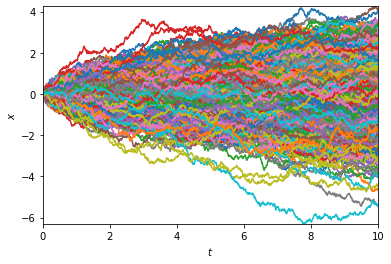

In [5]:
t=np.arange(0,T+dt,dt)
fig, ax = plt.subplots(1,1)
for walk in X:
  ax.plot(t,walk)
ax.set_xlim([t[0],t[-1]])
ax.set_ylim([np.min(X),np.max(X)])
ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
plt.show()

Let's find the mean squared displacement (MSD) and fit a curve to this in order verify the diffusion coefficient.

$$\mathrm{MSD}(t) \equiv \frac{1}{N}\sum_i |x^{(i)}(t)-x^{(i)}(0) |^2\,,$$

where $N$ is the number of random walkers, $t$ is the time we measure at, and overall we are finding the average distance $d_i=|x^{(i)}(t)-x^{(i)}(0) |$ each walker has achieved from its starting point during this time, then squaring it.

We can show for normally distributed $x^{(i)}$ that 
$$\mathrm{MSD}(t)=2Dt$$ where $D$ is the diffusion constant. This is actually because $\sigma^2=2Dt$ where $\sigma^2$ is the variance of the normal distribution modelling $x^{(i)}$, i.e. $x(t) \sim \mathcal{N}(x(0),\sigma^2=2Dt)$ (this is from the PDF).


[ 0.2039597  -0.00597445]


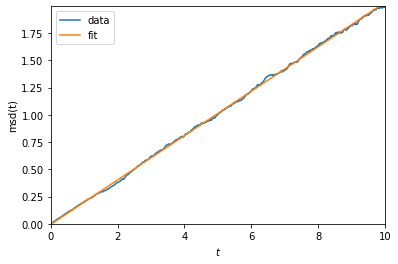

We estimate D 0.10197985079814062 with actual 0.1


In [7]:
def createMSDAndGetD(X,t,show=True,save_name=None):
  msd = np.average(X**2, axis=0)
  f = lambda t,m,c: m*t + c
  popt,pcov=scopt.curve_fit(f,t,msd)
  D_est=0.5*popt[0]
  print(popt)
  fig,ax=plt.subplots(1,1)
  ax.set_xlabel("$t$")
  ax.set_ylabel("msd(t)")
  ax.plot(t,msd,label="data")
  ax.plot(t,f(t,*popt),label="fit")
  ax.set_xlim([t[0],t[-1]])
  ax.set_ylim([msd.min(),msd.max()])
  plt.legend()
  if save_name != None:
    fig.savefig(save_name)
  if show:
    plt.show()
  else:
    plt.close()
  return D_est

D_est=createMSDAndGetD(X,t,show=True,save_name="figures/msd.png")
print(f"We estimate D {D_est} with actual {D}")

Check it turned out as expected...

Now let's find the PDF! The easiest method is to bin all the data from one time, and fit 

$$p(x;t=t_0)=\frac{e^{-\frac{x^2}{4Dt_0}}}{\sqrt{4\pi D t_0}}\,,$$

We need to fit our data to a pdf. [This might help!](https://www.gaussianwaves.com/2020/06/using-matplotlib-histogram-in-python/). Note I could have fit directly to this expected PDF but I left the problem as slightly more general as this is just a Gaussian (normal) distribution.

We use ```density=True``` in the plotting of the histogram so that we get a probability distribution. All this means is that the counts in each bin are divided by the total counts and the bin width, so that integrating the PDF gives 1.

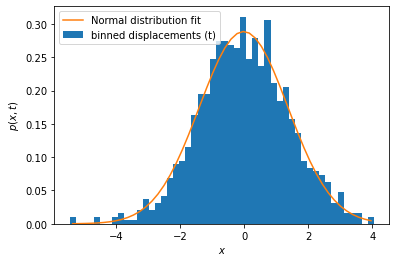

mu: -0.018068675346766493 sigma: 1.382564435556066 so D=0.09557422092322318


In [8]:
def PDF(x,mu,sigma):
  return np.exp(-((x-mu)**2/(2*sigma**2)))/(np.sqrt(2*np.pi*sigma**2))

posns=X[:,-1]   # Get all the last positions

def createPDFAndGetD(posns,T,save_name=None,show=True):
  # Create a figure and axies which we can add to
  fig, ax = plt.subplots(1,1)
  
  # Bin our data and create the histogram (this also plots the histogram)
  data, edges, _ = plt.hist(posns,bins=50,density=True,
                            label="binned displacements (t)")

  # Take the values of the PDF to be defined at the bin centres
  bin_centers = 0.5*(edges[1:] + edges[:-1])

  # Fit a normal distribution to the extracted PDF  
  popt, pcov = scopt.curve_fit(PDF,bin_centers,data)

  # Plot the fit and check it makes sense to model as a normal dist
  ax.plot(bin_centers,PDF(bin_centers,*popt),label="Normal distribution fit")
  
  ax.set_xlabel("$x$")
  ax.set_ylabel("$p(x,t)$")
  plt.legend()
  if save_name != None:
    fig.savefig(save_name)
  if show:
    plt.show()
  else:
    plt.close()

  mu, sig = popt
  D=sig**2/(2*T)
  print(f"mu: {mu} sigma: {sig} so D={D}")
  return D

D=createPDFAndGetD(posns,T,save_name="figures/hist.png")

In the following I create a example data for walkers with different diffusion constants, then try to measure these diffusion constants using both of the methods above, namely finding the MSD or fitting the PDF.

In [9]:
def createSampleData(M,N,dt,T):
  t=np.arange(0,T+dt,dt)
  for D in np.arange(0.2,4.0,1):
    print(f"creating data for {D}")
    X = simulateRandomWalker(M,N,dt,D)
    X=X.T
    columns=["t"]
    [ columns.append(f"X{ii}") for ii in range(M) ]
    df=pd.DataFrame(data=np.hstack((t[:,None],X)),columns=columns)
    df.to_csv(f"test/exp_{D}.txt",index=False,header=True)

In [10]:
createSampleData(M,N,dt,T)

creating data for 0.2
creating data for 1.2
creating data for 2.2
creating data for 3.2


In [11]:
def loadWalkerData(dir,save_name=None,var_name="independent variable"):
  """
  Load data from a specific directory. This code then goes through the data and
  find the MSD, the PDF, and plots the diffusion constant identified from both.
  """
  f = lambda s: float(os.path.splitext(os.path.basename(s))[0].split("_")[1])
  files = glob.glob(f"{dir}/*")
  files.sort(key=f)
  var = []
  D_msd = []
  D_pdf = []
  for file in files:
    print(f(file))
    var.append(f(file))
    data=pd.read_csv(file)
    narr=data.to_numpy()
    t=narr[:,0]
    X=narr[:,1:]
    D_msd_tmp = createMSDAndGetD(X.T,t,show=False,
                                 save_name=f"figures/msd_exp_{f(file)}.png"
                                 )
    D_msd.append(D_msd_tmp)
    D_pdf_tmp = createPDFAndGetD(X[-1],t[-1],
                                show=False,
                                save_name=f"figures/pdf_hist_exp_{f(file)}.png"
                                )
    D_pdf.append(D_pdf_tmp)
  
  fig,ax = plt.subplots(1,1)
  ax.scatter(var,D_pdf,label="D from PDF")
  ax.scatter(var,D_msd,label="D from MSD")
  ax.plot(var,var,label="Expected D")
  ax.set_ylabel("$D$")
  ax.set_xlabel(var_name)
  plt.legend()
  if save_name != None:
    fig.savefig(save_name)
  plt.show()

0.2
[ 0.43265667 -0.02314881]
mu: -0.021248119432120086 sigma: 2.0110076787448823 so D=0.202207594198544
1.2
[ 2.43329078 -0.34130073]
mu: -0.24765849116165825 sigma: 4.748506146324066 so D=1.1274155310838716
2.2
[3.88193577 0.93734681]
mu: -0.0680856080996883 sigma: 6.330921283122922 so D=2.004028214654939
3.2
[ 6.34042606 -0.82596625]
mu: -0.07566493906121435 sigma: 7.9378091273367835 so D=3.1504406871015576


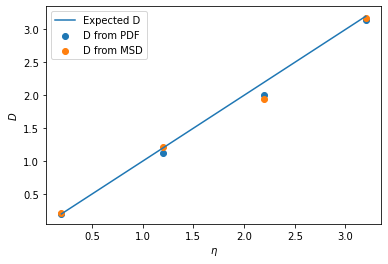

In [12]:
loadWalkerData("test",save_name="figures/test_run.png",var_name="$\eta$")